In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, \
                                    Flatten, Conv1D, MaxPooling1D, Dropout, \
                                    Concatenate, GlobalMaxPool1D, GlobalAvgPool1D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_cnn(conv_num=1):
    filter_size = 64

    input_layer = Input(shape=input_shape)
    x = input_layer

    layer_outputs = []
    for i in range(conv_num):
        x = Conv1D (kernel_size=5, filters=filter_size*(2**(i//4)), 
                          strides=1, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling1D(pool_size=3, strides=3)(x)
        layer_outputs.append(x)    
    
    x = Concatenate()([GlobalMaxPool1D()(output) for output in layer_outputs[-2:]])
    x = BatchNormalization()(x)
    x = Dense(output_size, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=x)
    return model

In [9]:
for i in range(3, 9):
    model = build_cnn(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 16000, 64)    384         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 16000, 64)    256         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 16000, 64)    0           batch_normalization_v1[0][0]     
_____________________________________

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 16000, 64)    384         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_9 (Batch (None, 16000, 64)    256         conv1d_7[0][0]                   
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 16000, 64)    0           batch_normalization_v1_9[0][0]   
__________________________________________________________________________________________________
max_poolin

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 16000, 64)    384         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_22 (Batc (None, 16000, 64)    256         conv1d_18[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 16000, 64)    0           batch_normalization_v1_22[0][0]  
__________________________________________________________________________________________________
max_poolin

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0975 - acc: 0.3231
Epoch 00001: val_loss improved from inf to 2.04945, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_BN_3_conv_checkpoint/001-2.0495.hdf5
36805/36805 [==============================] - 55s 1ms/sample - loss: 2.0974 - acc: 0.3231 - val_loss: 2.0495 - val_acc: 0.3305
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5718 - acc: 0.4865
Epoch 00002: val_loss improved from 2.04945 to 1.46002, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_BN_3_conv_checkpoint/002-1.4600.hdf5
36805/36805 [==============================] - 51s 1ms/sample - loss: 1.5718 - acc: 0.4865 - val_loss: 1.4600 - val_acc: 0.5260
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4687 - acc: 0.8579
Epoch 00023: val_loss did not improve from 0.56080
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.4687 - acc: 0.8579 - val_loss: 0.5739 - val_acc: 0.8279
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4544 - acc: 0.8618
Epoch 00024: val_loss did not improve from 0.56080
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.4544 - acc: 0.8618 - val_loss: 0.5612 - val_acc: 0.8300
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4443 - acc: 0.8646
Epoch 00025: val_loss improved from 0.56080 to 0.53880, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_BN_3_conv_checkpoint/025-0.5388.hdf5
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.4446 - acc: 0.8646 - val_loss: 0.5388 - val_acc: 0.8409
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - l

36800/36805 [============================>.] - ETA: 0s - loss: 0.2944 - acc: 0.9115
Epoch 00051: val_loss did not improve from 0.48939
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.2944 - acc: 0.9116 - val_loss: 0.5619 - val_acc: 0.8325
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2878 - acc: 0.9130
Epoch 00052: val_loss did not improve from 0.48939
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.2879 - acc: 0.9130 - val_loss: 0.5597 - val_acc: 0.8355
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2847 - acc: 0.9142
Epoch 00053: val_loss did not improve from 0.48939
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.2847 - acc: 0.9142 - val_loss: 0.5575 - val_acc: 0.8311
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2828 - acc: 0.9137
Epoch 00054: val_loss did not improve from 0.48939
36805/36805 [========================

Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2052 - acc: 0.9368
Epoch 00081: val_loss did not improve from 0.48939
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.2052 - acc: 0.9367 - val_loss: 0.5599 - val_acc: 0.8358
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2000 - acc: 0.9395
Epoch 00082: val_loss did not improve from 0.48939
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.2001 - acc: 0.9395 - val_loss: 0.5885 - val_acc: 0.8309
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1966 - acc: 0.9402
Epoch 00083: val_loss did not improve from 0.48939
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.1967 - acc: 0.9401 - val_loss: 0.5868 - val_acc: 0.8339
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1993 - acc: 0.9390
Epoch 00084: val_loss did not improve from 0.48939
36805/36805 [===========

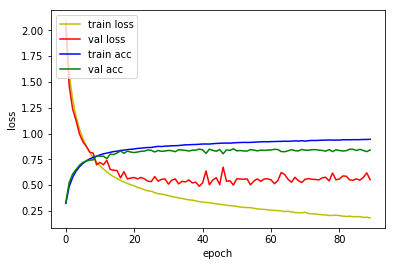

4815/4815 [==============================] - 3s 553us/sample - loss: 0.5636 - acc: 0.8258
Loss: 0.5635875388221702 Accuracy: 0.82575285

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9947 - acc: 0.3668
Epoch 00001: val_loss improved from inf to 1.86121, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_BN_4_conv_checkpoint/001-1.8612.hdf5
36805/36805 [==============================] - 56s 2ms/sample - loss: 1.9947 - acc: 0.3668 - val_loss: 1.8612 - val_acc: 0.4263
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3548 - acc: 0.5738
Epoch 00002: val_loss improved from 1.86121 to 1.21262, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_BN_4_conv_checkpoint/002-1.2126.hdf5
36805/36805 [==============================] - 53s 1ms/sample - loss: 1.3548 - acc: 0.5738 - val_loss: 1.2126 - val_acc: 0.6124
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2387 - acc: 0.9327
Epoch 00025: val_loss did not improve from 0.40314
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.2389 - acc: 0.9326 - val_loss: 0.4166 - val_acc: 0.8672
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2288 - acc: 0.9366
Epoch 00026: val_loss did not improve from 0.40314
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.2289 - acc: 0.9366 - val_loss: 0.4291 - val_acc: 0.8651
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2236 - acc: 0.9374
Epoch 00027: val_loss improved from 0.40314 to 0.38326, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_BN_4_conv_checkpoint/027-0.3833.hdf5
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.2236 - acc: 0.9374 - val_loss: 0.3833 - val_acc: 0.8838
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - l

36800/36805 [============================>.] - ETA: 0s - loss: 0.0890 - acc: 0.9779
Epoch 00053: val_loss did not improve from 0.37413
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.0891 - acc: 0.9779 - val_loss: 0.4262 - val_acc: 0.8826
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0912 - acc: 0.9772
Epoch 00054: val_loss did not improve from 0.37413
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.0913 - acc: 0.9772 - val_loss: 0.3992 - val_acc: 0.8875
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0847 - acc: 0.9796
Epoch 00055: val_loss did not improve from 0.37413
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.0847 - acc: 0.9796 - val_loss: 0.4183 - val_acc: 0.8826
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0774 - acc: 0.9816
Epoch 00056: val_loss did not improve from 0.37413
36805/36805 [========================

Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0409 - acc: 0.9907
Epoch 00083: val_loss did not improve from 0.37413
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.0412 - acc: 0.9906 - val_loss: 0.4617 - val_acc: 0.8861
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0513 - acc: 0.9865
Epoch 00084: val_loss did not improve from 0.37413
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.0516 - acc: 0.9864 - val_loss: 0.4754 - val_acc: 0.8807
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0472 - acc: 0.9886
Epoch 00085: val_loss did not improve from 0.37413
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.0472 - acc: 0.9886 - val_loss: 0.4537 - val_acc: 0.8817
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0322 - acc: 0.9938
Epoch 00086: val_loss did not improve from 0.37413
36805/36805 [===========

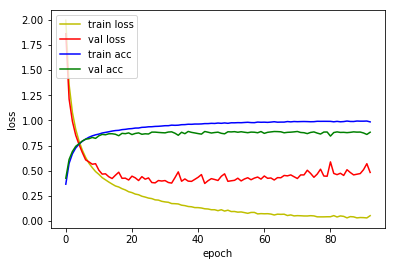

4815/4815 [==============================] - 3s 602us/sample - loss: 0.4251 - acc: 0.8654
Loss: 0.4251129043003233 Accuracy: 0.8654206

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6348 - acc: 0.4916
Epoch 00001: val_loss improved from inf to 1.45596, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_BN_5_conv_checkpoint/001-1.4560.hdf5
36805/36805 [==============================] - 60s 2ms/sample - loss: 1.6348 - acc: 0.4916 - val_loss: 1.4560 - val_acc: 0.5190
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8423 - acc: 0.7541
Epoch 00002: val_loss improved from 1.45596 to 0.70768, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_BN_5_conv_checkpoint/002-0.7077.hdf5
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.8423 - acc: 0.7541 - val_loss: 0.7077 - val_acc: 0.8011
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s 

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0569 - acc: 0.9891
Epoch 00026: val_loss did not improve from 0.24471
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.0569 - acc: 0.9891 - val_loss: 0.2795 - val_acc: 0.9180
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0545 - acc: 0.9895
Epoch 00027: val_loss did not improve from 0.24471
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.0546 - acc: 0.9895 - val_loss: 0.2634 - val_acc: 0.9213
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0555 - acc: 0.9886
Epoch 00028: val_loss did not improve from 0.24471
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.0556 - acc: 0.9886 - val_loss: 0.2708 - val_acc: 0.9245
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0479 - acc: 0.9919
Epoch 00029: val_loss did not improve from 0.24471
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0115 - acc: 0.9989
Epoch 00055: val_loss did not improve from 0.24288
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.0115 - acc: 0.9989 - val_loss: 0.2740 - val_acc: 0.9297
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0104 - acc: 0.9988
Epoch 00056: val_loss did not improve from 0.24288
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.0104 - acc: 0.9988 - val_loss: 0.2678 - val_acc: 0.9324
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0129 - acc: 0.9980
Epoch 00057: val_loss did not improve from 0.24288
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.0130 - acc: 0.9980 - val_loss: 0.2936 - val_acc: 0.9266
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0143 - acc: 0.9972
Epoch 00058: val_loss did not improve from 0.24288
36805/36805 [========================

Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0226 - acc: 0.9936
Epoch 00085: val_loss did not improve from 0.24288
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.0226 - acc: 0.9936 - val_loss: 0.2993 - val_acc: 0.9292
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0047 - acc: 0.9996
Epoch 00086: val_loss did not improve from 0.24288
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.0047 - acc: 0.9996 - val_loss: 0.2980 - val_acc: 0.9348

1D_CNN_custom_multi_2_GMP_BN_5_conv Model


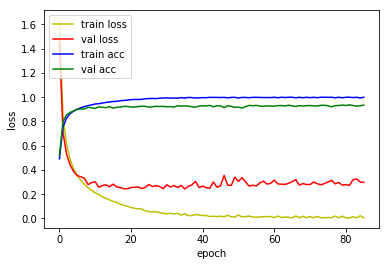

4815/4815 [==============================] - 3s 634us/sample - loss: 0.2825 - acc: 0.9221
Loss: 0.28251868444315986 Accuracy: 0.92211837

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2951 - acc: 0.6087
Epoch 00001: val_loss improved from inf to 1.00217, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_BN_6_conv_checkpoint/001-1.0022.hdf5
36805/36805 [==============================] - 64s 2ms/sample - loss: 1.2950 - acc: 0.6088 - val_loss: 1.0022 - val_acc: 0.7470
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5466 - acc: 0.8476
Epoch 00002: val_loss improved from 1.00217 to 0.46507, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_BN_6_conv_checkpoint/002-0.4651.hdf5
36805/36805 [==============================] - 55s 2ms/sample - loss: 0.5467 - acc: 0.8476 - val_loss: 0.4651 - val_acc: 0.8733
Epoch 3/500
36800/36805 [============================>.] - ETA: 0

36800/36805 [============================>.] - ETA: 0s - loss: 0.0241 - acc: 0.9968
Epoch 00025: val_loss did not improve from 0.17737
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.0241 - acc: 0.9968 - val_loss: 0.1918 - val_acc: 0.9457
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0330 - acc: 0.9936
Epoch 00026: val_loss did not improve from 0.17737
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.0330 - acc: 0.9936 - val_loss: 0.1998 - val_acc: 0.9446
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0228 - acc: 0.9966
Epoch 00027: val_loss did not improve from 0.17737
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.0228 - acc: 0.9966 - val_loss: 0.2145 - val_acc: 0.9380
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0247 - acc: 0.9959
Epoch 00028: val_loss did not improve from 0.17737
36805/36805 [========================

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0166 - acc: 0.9962
Epoch 00055: val_loss did not improve from 0.17616
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.0168 - acc: 0.9962 - val_loss: 0.2202 - val_acc: 0.9434
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0169 - acc: 0.9956
Epoch 00056: val_loss did not improve from 0.17616
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.0169 - acc: 0.9956 - val_loss: 0.1901 - val_acc: 0.9511
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0034 - acc: 0.9998
Epoch 00057: val_loss did not improve from 0.17616
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.0034 - acc: 0.9998 - val_loss: 0.1767 - val_acc: 0.9555
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0024 - acc: 0.9999
Epoch 00058: val_loss did not improve from 0.17616
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0142 - acc: 0.9960
Epoch 00084: val_loss did not improve from 0.17325
36805/36805 [==============================] - 55s 2ms/sample - loss: 0.0143 - acc: 0.9960 - val_loss: 0.1973 - val_acc: 0.9546
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0101 - acc: 0.9977
Epoch 00085: val_loss did not improve from 0.17325
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.0101 - acc: 0.9977 - val_loss: 0.2013 - val_acc: 0.9529
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0024 - acc: 0.9998
Epoch 00086: val_loss did not improve from 0.17325
36805/36805 [==============================] - 55s 2ms/sample - loss: 0.0024 - acc: 0.9998 - val_loss: 0.1920 - val_acc: 0.9543
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0052 - acc: 0.9990
Epoch 00087: val_loss did not improve from 0.17325
36805/36805 [========================

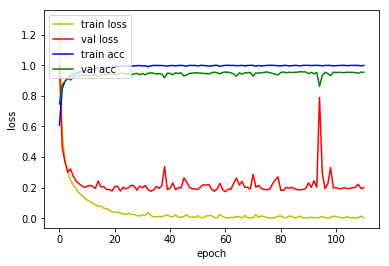

4815/4815 [==============================] - 3s 690us/sample - loss: 0.1879 - acc: 0.9493
Loss: 0.1879012505151525 Accuracy: 0.949325

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0641 - acc: 0.6801
Epoch 00001: val_loss improved from inf to 0.82575, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_BN_7_conv_checkpoint/001-0.8257.hdf5
36805/36805 [==============================] - 68s 2ms/sample - loss: 1.0643 - acc: 0.6800 - val_loss: 0.8257 - val_acc: 0.7787
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4041 - acc: 0.8829
Epoch 00002: val_loss improved from 0.82575 to 0.31702, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_BN_7_conv_checkpoint/002-0.3170.hdf5
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.4042 - acc: 0.8829 - val_loss: 0.3170 - val_acc: 0.9157
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s -

36800/36805 [============================>.] - ETA: 0s - loss: 0.0203 - acc: 0.9961
Epoch 00027: val_loss improved from 0.14757 to 0.14582, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_BN_7_conv_checkpoint/027-0.1458.hdf5
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0203 - acc: 0.9961 - val_loss: 0.1458 - val_acc: 0.9555
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0078 - acc: 0.9993
Epoch 00028: val_loss did not improve from 0.14582
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0078 - acc: 0.9993 - val_loss: 0.1692 - val_acc: 0.9557
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0068 - acc: 0.9994
Epoch 00029: val_loss did not improve from 0.14582
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0068 - acc: 0.9994 - val_loss: 0.1654 - val_acc: 0.9557
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0072 -

36800/36805 [============================>.] - ETA: 0s - loss: 0.0022 - acc: 0.9998
Epoch 00056: val_loss did not improve from 0.14582
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0022 - acc: 0.9998 - val_loss: 0.1895 - val_acc: 0.9550
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0110 - acc: 0.9969
Epoch 00057: val_loss did not improve from 0.14582
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0110 - acc: 0.9969 - val_loss: 0.1525 - val_acc: 0.9599
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0150 - acc: 0.9957
Epoch 00058: val_loss did not improve from 0.14582
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0150 - acc: 0.9957 - val_loss: 0.1461 - val_acc: 0.9627
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0027 - acc: 0.9997
Epoch 00059: val_loss did not improve from 0.14582
36805/36805 [========================

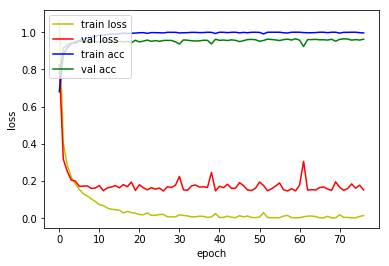

4815/4815 [==============================] - 3s 688us/sample - loss: 0.1756 - acc: 0.9462
Loss: 0.17561202078655377 Accuracy: 0.9462098

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0398 - acc: 0.6812
Epoch 00001: val_loss improved from inf to 0.76252, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_BN_8_conv_checkpoint/001-0.7625.hdf5
36805/36805 [==============================] - 71s 2ms/sample - loss: 1.0399 - acc: 0.6812 - val_loss: 0.7625 - val_acc: 0.7768
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4001 - acc: 0.8778
Epoch 00002: val_loss improved from 0.76252 to 0.31461, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_BN_8_conv_checkpoint/002-0.3146.hdf5
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.4000 - acc: 0.8778 - val_loss: 0.3146 - val_acc: 0.9019
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0118 - acc: 0.9979
Epoch 00027: val_loss did not improve from 0.15689
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0118 - acc: 0.9979 - val_loss: 0.2034 - val_acc: 0.9488
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0151 - acc: 0.9967
Epoch 00028: val_loss did not improve from 0.15689
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0153 - acc: 0.9967 - val_loss: 0.2133 - val_acc: 0.9418
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0322 - acc: 0.9906
Epoch 00029: val_loss improved from 0.15689 to 0.15645, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_BN_8_conv_checkpoint/029-0.1565.hdf5
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0322 - acc: 0.9906 - val_loss: 0.1565 - val_acc: 0.9574
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - l

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0059 - acc: 0.9988
Epoch 00056: val_loss did not improve from 0.15082
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0059 - acc: 0.9988 - val_loss: 0.1746 - val_acc: 0.9595
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0040 - acc: 0.9991
Epoch 00057: val_loss did not improve from 0.15082
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0040 - acc: 0.9991 - val_loss: 0.1918 - val_acc: 0.9567
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0053 - acc: 0.9987
Epoch 00058: val_loss did not improve from 0.15082
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0053 - acc: 0.9987 - val_loss: 0.2714 - val_acc: 0.9404
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0062 - acc: 0.9987
Epoch 00059: val_loss did not improve from 0.15082
36805/36805 [===========

Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0088 - acc: 0.9978
Epoch 00086: val_loss did not improve from 0.15082
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0088 - acc: 0.9978 - val_loss: 0.1798 - val_acc: 0.9623
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0023 - acc: 0.9996
Epoch 00087: val_loss did not improve from 0.15082
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0023 - acc: 0.9996 - val_loss: 0.1908 - val_acc: 0.9585
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0068 - acc: 0.9983
Epoch 00088: val_loss did not improve from 0.15082
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0068 - acc: 0.9983 - val_loss: 0.1826 - val_acc: 0.9599
Epoch 89/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0017 - acc: 0.9997
Epoch 00089: val_loss did not improve from 0.15082
36805/36805 [===========

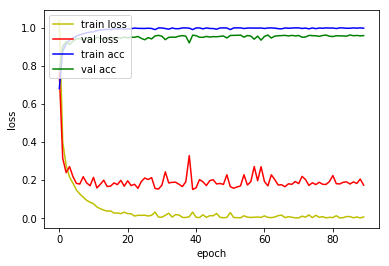

4815/4815 [==============================] - 4s 764us/sample - loss: 0.2088 - acc: 0.9433
Loss: 0.20877599846784448 Accuracy: 0.94330215



In [10]:
base = '1D_CNN_custom_multi_2_GMP_BN'

for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    model = build_cnn(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_multi_2_GMP_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 9):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_multi_2_GMP_BN_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 64)    384         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_39 (Batc (None, 16000, 64)    256         conv1d_33[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 64)    0           batch_normalization_v1_39[0][0]  
__________________________________________________________________

4815/4815 [==============================] - 3s 717us/sample - loss: 0.4251 - acc: 0.8654
Loss: 0.4251129043003233 Accuracy: 0.8654206

1D_CNN_custom_multi_2_GMP_BN_5_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 16000, 64)    384         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_48 (Batc (None, 16000, 64)    256         conv1d_40[0][0]                  
__________________________________________________________________________________________________
activation_40 (Activation)    

4815/4815 [==============================] - 4s 791us/sample - loss: 0.1879 - acc: 0.9493
Loss: 0.1879012505151525 Accuracy: 0.949325

1D_CNN_custom_multi_2_GMP_BN_7_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 16000, 64)    384         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_v1_61 (Batc (None, 16000, 64)    256         conv1d_51[0][0]                  
__________________________________________________________________________________________________
activation_51 (Activation)     

4815/4815 [==============================] - 4s 818us/sample - loss: 0.2088 - acc: 0.9433
Loss: 0.20877599846784448 Accuracy: 0.94330215


In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
# base = '1D_CNN_custom_BN_2'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_multi_2_GMP_BN_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 64)    384         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_39 (Batc (None, 16000, 64)    256         conv1d_33[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 64)    0           batch_normalization_v1_39[0][0]  
__________________________________________________________________

4815/4815 [==============================] - 4s 865us/sample - loss: 0.5342 - acc: 0.8669
Loss: 0.5341947954020396 Accuracy: 0.86687434

1D_CNN_custom_multi_2_GMP_BN_5_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 16000, 64)    384         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_48 (Batc (None, 16000, 64)    256         conv1d_40[0][0]                  
__________________________________________________________________________________________________
activation_40 (Activation)   

4815/4815 [==============================] - 4s 903us/sample - loss: 0.2020 - acc: 0.9522
Loss: 0.20200930233398764 Accuracy: 0.9522326

1D_CNN_custom_multi_2_GMP_BN_7_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 16000, 64)    384         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_v1_61 (Batc (None, 16000, 64)    256         conv1d_51[0][0]                  
__________________________________________________________________________________________________
activation_51 (Activation)   

4815/4815 [==============================] - 5s 971us/sample - loss: 0.2142 - acc: 0.9472
Loss: 0.21416281622748432 Accuracy: 0.94724816
